In [1]:
import pandas as pd
df = pd.read_csv("retweet_association.csv")
seed = 10

# Retweet association to the original tweet
The dataset includes the link to the original post as well as the link to the retweet. The `orig_username` is the username extracted from the `retweeeted_from` which is the original link. The `retweeters_username` is the username extracted from the `post_link` column.

**NOTE**: No longer existing users are inputted as: `N/A Suspended`

In [2]:
print("%s unique usernames from people retweeting" % len(df.retweeters_username.unique()))
print("%s unique users being retweeted" % len(df.orig_username.unique()))

109674 unique usernames from people retweeting
25386 unique users being retweeted


In [3]:
df.head(3)

,tweet_num,tweet_type,retweeters_username,orig_username,post_link,retweeted_from
0,1,retweet,Gen_Ago,th1an1,http://twitter.com/Gen_Ago/statuses/8823888952...,https://twitter.com/th1an1/status/882319618718...
1,2,retweet,KSKersey,markanames,http://twitter.com/KSKersey/statuses/882388579...,https://twitter.com/markanames/status/88238280...
2,3,retweet,radar_kameradin,eatps_,http://twitter.com/radar_kameradin/statuses/88...,https://twitter.com/eatps_/status/882350652978...


# Plotting people retweeting
i.e. users who retweeted others original tweets.

In [4]:
import math
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#plt.style.use("fivethirtyeight")

In [5]:
people_retweeting = df.groupby("retweeters_username").retweeters_username.count()
people_retweeting.sample(3, random_state=seed)

retweeters_username
SaDCDB          1
pointatmecom    1
Leszequi        3
Name: retweeters_username, dtype: int64

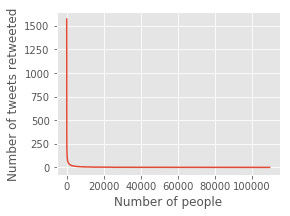

In [6]:
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)

ax1.plot(
    range(len(df.retweeters_username.unique())),
    people_retweeting.sort_values(ascending=False))
ax1.set_xlabel("Number of people")
ax1.set_ylabel("Number of tweets retweeted")
plt.show()

In [7]:
# The top 10 retweeting users:
people_retweeting.sort_values(ascending=False).head(10)

retweeters_username
moetant36          1569
UnitedBlackRed     1110
petera4711          917
psychischesprbl     908
PalmarxRaul         841
PParzival           840
frisch_fish         603
anubidal            564
VVNkrefeld          560
MARKANTdjPOOL       556
Name: retweeters_username, dtype: int64

# Plotting people being retweeted

In [8]:
people_retweeted = df.groupby("orig_username").orig_username.count()
people_retweeted.sample(3, random_state=seed)

orig_username
trainofhopecgn    4
MarcoZehe         1
JessiStein100     2
Name: orig_username, dtype: int64

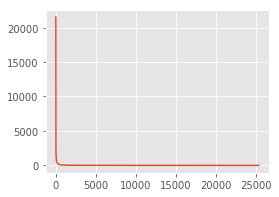

In [9]:
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)

ax1.plot(
    range(len(people_retweeted)),
    people_retweeted.sort_values(ascending=False)
)
plt.show()

In [10]:
# Show the top 10 retweeted users:
people_retweeted.sort_values(ascending=False).head(10)

orig_username
PolizeiHamburg    21519
N/A Suspended     12907
kaanelbir          5229
waskevinsagt       4166
Der_Postillon      3751
_ju1_              3701
ndaktuell          3671
AntifaMadrid       3502
enough14           3129
SPIEGELONLINE      3126
Name: orig_username, dtype: int64

# Relationship between violence score and retweets

In [11]:
viol_data = pd.read_csv(
    "annotated.csv"
)
viol_data["post_link"] = viol_data["post_link"].apply(
    lambda x: x.replace("http://", "https://")
)

import re
rex = re.compile("[0-9]+$")

def find_id(x):
    try:
        return rex.findall(x)[0]
    except:
        return None

viol_data["post_id"] = viol_data["post_link"].apply(find_id)
viol_data.head(3)

,Unnamed: 0,tweet_num,tweet_type,post_link,name,pred_protest,pred_violence,post_id
0,0,0,tweet,https://twitter.com/mzphoto_org/statuses/88264...,https___pbs.twimg.com_media_DD_GFQsW0AAZy5-.jpg,0.023730,0.409450,882641894458707970
1,1,0,tweet,https://twitter.com/mzphoto_org/statuses/88264...,https___pbs.twimg.com_media_DD_GFQlWAAAkCdj.jpg,0.204886,0.316682,882641894458707970
2,2,0,tweet,https://twitter.com/mzphoto_org/statuses/88264...,https___pbs.twimg.com_media_DD_GFQpW0AIms1Z.jpg,0.926072,0.357391,882641894458707970


In [12]:
df["post_id"] = df.retweeted_from.apply(find_id)
df_has_orig = df[df.post_id.isin(viol_data.post_id.values)]
orig_has_retweet = viol_data[viol_data.post_id.isin(df.post_id.values)]
print("%s unique post ids" % len(df_has_orig.post_id.unique()))
print("%s total retweets where the original post was found in annotated sets" % len(df_has_orig))
print("_" * 80)

14341 unique post ids
174520 total retweets where the original post was found in annotated sets
________________________________________________________________________________


In [13]:
def get_grouped(based_on="mean"):
    orig_mean_viol = orig_has_retweet[["pred_violence", "pred_protest", "post_id"]].groupby("post_id")
    if based_on == "mean": 
        orig_mean_viol = orig_mean_viol.mean()
    elif based_on == "max":
        orig_mean_viol = orig_mean_viol.max()
    else:
        raise ValueError("'%s' not understood" % based_on)
        
    tmp = df_has_orig[["post_id", "post_link"]].groupby("post_id").count().rename(columns={"post_link": "retweets"})
    orig_mean_viol["retweets"] = tmp["retweets"]
    
    return orig_mean_viol

In [14]:
orig_mean_viol = get_grouped()
orig_mean_viol.corr() # Correlations matrix,
                      # including correlation between number of retweets and level of violence

,pred_violence,pred_protest,retweets
pred_violence,1.000000,0.503068,-0.015145
pred_protest,0.503068,1.000000,-0.012039
retweets,-0.015145,-0.012039,1.000000


From the above, it seems that from the 14 000 images with type `tweet` in the original datasets `post_type` column, the models prediction of violence and protest related, has no correlation with the number of retweets. 

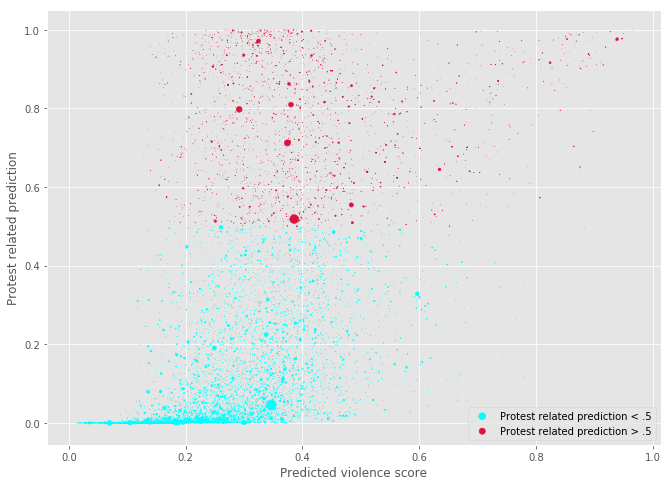

In [15]:
def plot():
    fig = plt.figure(figsize=(11,8))
    ax1 = fig.add_subplot(111)

    ma, mi = orig_mean_viol.max(), orig_mean_viol.min()
    m, s = orig_mean_viol.mean(), orig_mean_viol.std()

    lower_half = orig_mean_viol[orig_mean_viol["pred_protest"] <= .5]
    larger_half = orig_mean_viol[orig_mean_viol["pred_protest"] > .5]
    lower = ax1.scatter(
        lower_half.pred_violence,
        lower_half.pred_protest,
        s=[((x.retweets /mi.retweets)/ (ma.retweets - mi.retweets)) * 100 for _, x in lower_half.iterrows()],
        c=["cyan"] * len(lower_half)
    )
    larger = ax1.scatter(
        larger_half.pred_violence,
        larger_half.pred_protest,
        s=[((x.retweets /mi.retweets)/ (ma.retweets - mi.retweets)) * 100 for _, x in larger_half.iterrows()],
        c=["crimson"] * len(larger_half)
    )
    ax1.set_ylabel("Protest related prediction")
    ax1.set_xlabel("Predicted violence score")
    plt.legend(
        handles=[lower, larger],
        labels=["Protest related prediction < .5", "Protest related prediction > .5"],
        loc="lower right",
    )
    return plt

plot().show()

In the above graph, the size of each circle is given by the min-max standardized value of the number of retweets (scaled by 100). The color is directly related to the y axis, and is just thresholded so that all marks of tweets with images that on average were not predicted to be protest related are colored cyan. All tweets with the average score of images as protest related were colored red.

The above plot requires linking *n* number of images to exactly one tweet, and each image may be associated with different levels of violence score and/or probability of being protest related. In the above the average score is used, however each tweet could also have been associated with the max score of any attached images. Below is the same plot, but each tweet associated with the max scores of any of its images

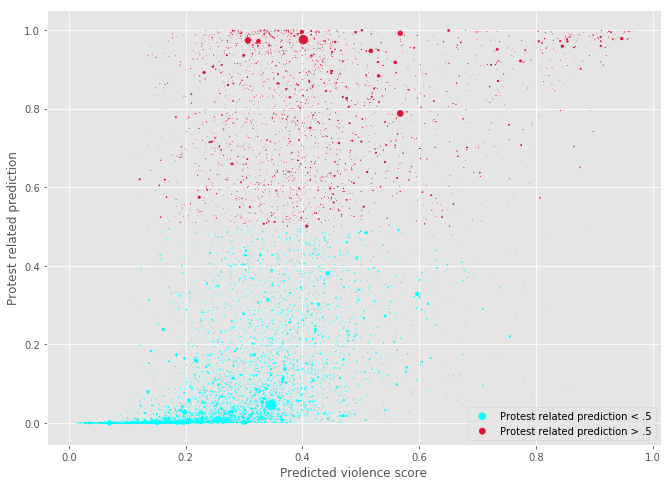

In [16]:
orig_mean_viol = get_grouped("max")
plot().show()

The interpretability is slightly easier when using the max value, as we dont know from the plot alone how many images are represented for any given tweet (as seen as one dot in the graph).
Also, more interesting, the most retweeted has images with either very high probability of being protest related (probably news worthy) or very low (which, when looking at the model tends to be memes, so this might represent more humoristic tweets)

# Relation between retweets and level of violence
Lastly, exploring the relation between retweets and violence as the threshold of protest and violence scores are adjusted so that only images above the threshold is kept. Then plotting how the correlation between the number of retweets and the level of violence predicted by the model correlates. Ideally, a correlational pattern will emerge as the threshold is increased indicating a threshold for which point the memes and screenshots are be filtered out.

The first plot will use the `pred_protest` column to find a threshold, the second will use the `pred_violence`. As such, the x axis will show the threshold used and the y will show the correlation between violence and retweets for images with scores above the threshold. 

For convenience, let the level of violence for a given tweet be defined by the maximum value for any images included in the tweet. As was the case above, this could also be defined by the average score of images for every tweet.

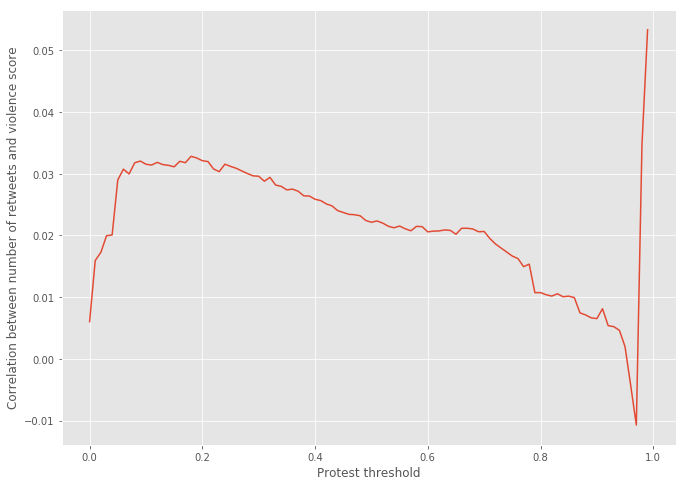

In [53]:
import numpy as np

# Just change the parameter "max" to "mean" to define the violence for a tweet by its average score:
orig_max_viol = get_grouped("max")

thresholds = [x / 100 for x in range(0, 100)] # as range works only for integers
correlations = []
for t in thresholds:
    above = orig_max_viol[orig_max_viol["pred_protest"] >= t]
    corr_val = above[
        ["retweets", "pred_violence"]
    ].corr().pred_violence.iloc[0]  # correlation between retweets
                                    # and violence prediction
                                    # for images above threshold t
    
    if not np.isnan(corr_val):
        # If there are no images above t, the value will be NaN
        correlations.append(corr_val)

# include only as many threshold as are values, since the thresholds is incremental,
# any missing values k will be for k > n:
thresholds = thresholds[:len(correlations)]
assert len(thresholds) == len(correlations), "Should be same number of ys and xs"

# Plotting:
fig = plt.figure(figsize=(11, 8))
ax1 = fig.add_subplot(111)
ax1.plot(
    thresholds,
    correlations
)
ax1.set_xlabel("Protest threshold")
ax1.set_ylabel("Correlation between number of retweets and violence score")
plt.show()

Make of that what you will :D
    
Below is the same, but using thresholds on `pred_violence`

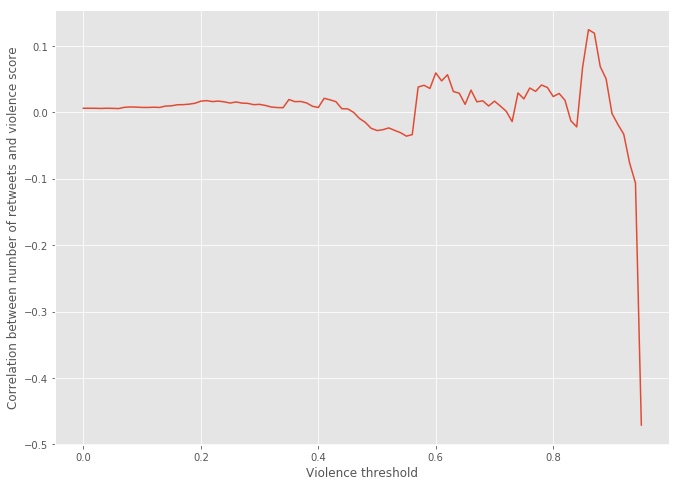

In [54]:
import numpy as np

# Just change the parameter "max" to "mean" to define the violence for a tweet by its average score:
orig_max_viol = get_grouped("max")

thresholds = [x / 100 for x in range(0, 100)] # as range works only for integers
correlations = []
for t in thresholds:
    above = orig_max_viol[orig_max_viol["pred_violence"] >= t]
    corr_val = above[
        ["retweets", "pred_violence"]
    ].corr().pred_violence.iloc[0]  # correlation between retweets
                                    # and violence prediction
                                    # for images above threshold t
    
    if not np.isnan(corr_val):
        # If there are no images above t, the value will be NaN
        correlations.append(corr_val)

# include only as many threshold as are values, since the thresholds is incremental,
# any missing values k will be for k > n:
thresholds = thresholds[:len(correlations)]
assert len(thresholds) == len(correlations), "Should be same number of ys and xs"

# Plotting:
fig = plt.figure(figsize=(11, 8))
ax1 = fig.add_subplot(111)
ax1.plot(
    thresholds,
    correlations
)
ax1.set_xlabel("Violence threshold")
ax1.set_ylabel("Correlation between number of retweets and violence score")
plt.show()

At some point theres a descent negative correlation between violence and retweets. Of course, the significance of this depends on the number of tweets above such a threshold:

In [52]:
print("{:<20} | {:<16}".format("Violence threshold", "Number of tweets"))
print("_" * 42)
for i in range(0, 100):
    t = i/100
    tweets = orig_max_viol[orig_max_viol["pred_violence"] >= t]
    print("{:<20} | {:<16}".format(t, len(tweets)))
    print("_" * 42)

Violence threshold   | Number of tweets
__________________________________________
0.0                  | 14341           
__________________________________________
0.01                 | 14341           
__________________________________________
0.02                 | 14332           
__________________________________________
0.03                 | 14305           
__________________________________________
0.04                 | 14271           
__________________________________________
0.05                 | 14242           
__________________________________________
0.06                 | 14199           
__________________________________________
0.07                 | 14120           
__________________________________________
0.08                 | 14071           
__________________________________________
0.09                 | 13985           
__________________________________________
0.1                  | 13889           
__________________________________________
0.11